In [1]:
import re

import keras.backend as keras_backend
from keras.layers import Conv1D, Lambda, Add
import numpy as np

from traits.api import Enum, HasStrictTraits, Int, Instance, List, Tuple

from blusky.transforms.cascade_tree import CascadeTree
from blusky.transforms.default_decimation import (NoDecimation, 
                                                  DefaultDecimation)
from blusky.transforms.i_decimation_method import IDecimationMethod
from blusky.wavelets.i_wavelet_1d import IWavelet1D

Using TensorFlow backend.


In [10]:
def pad_to_log2(img, mode='reflect', constant_value=0):
    """
    To properly align the transform at multiple scales, we need 
    the size of the input image to be a power of 2, so, 
    2, 4, 8, 16, ... etc. 
    This function applies a padding resize to the nearest (larger) 
    power of 2. 
    
    Parameters
    ----------
    img - Array
        A 1d image in numpy format.
    mode - Unicode
        (optional) numpy pad modes,
    constant_value - Float or Int
        (optional) if mode 'constant' use this constant value.
    
    Returns
    -------
    padded image - Array
        The padded image.
    """
    
    dh = 2**np.ceil(np.log2(img.shape[0])) - img.shape[0]

    _dh1 = int(dh//2)
    _dh2 = int(_dh1 + dh%2)        
    
    if mode == 'constant':
        return np.pad(img, _dh1, mode=mode, 
                      constant_values=constant_value)
    else:
        return np.pad(img, _dh1, mode=mode)


In [2]:
class Cascade1D(HasStrictTraits):
    """
    Caution this has a bug.

    The idea here is to implement a cascade of convolvolution
    and modulus opertations.
    Suppose I had a sequence of wavelets, psi1, psi2, ...

    |x * psi1|
    |x * psi2| -> output
        .
        .
        .
     ---> ||x * psi1| * psi2|
          ||x * psi1| * psi3|
                .               -> output
                .
          ||x * psi2| * psi3|
                .
                .
                  |
                  |
                  ---> .. etc ..
    """

    #: Provides methods for decimating at each layer in the transform.
    decimation = Instance(IDecimationMethod, NoDecimation())

    #: Subsequent convolutions can be applied to downsampled images for
    #  efficiency.
    # Provide some options with Keras for this:
    # Max - MaxPooling (take max value in a window)
    # Average - AveragePooling (average values in window)
    pooling_type = Enum(["none", "max", "average"])

    # shape of the input tile
    shape = Tuple(Int)

    #: In 2D we will apply the transform over a set of wavelets are different
    # orientation, define that here in degrees.
    angles = Tuple

    #: Direction to Keras Conv2d on how to do padding at each convolution,
    #  "same" pads with zeros, "valid" doesn't. This doesn't replace the
    #  need to pad tiles during preprocessing, however, "same" will maintain
    #  tile size through each layer.
    #  "valid" is faster.
    _padding = Enum(["same", "valid"])

    #: private, labels endpoints to attach things to
    _endpoint_counter = Int(0)

    #:
    _current_order = Int(1)

    def _init_weights(
        self, shape, node=None, dtype=None, wavelet1d=None, real_part=True
    ):
        """
        Create an initializer for Conv1D layers. 

        Parameters
        ----------
        wavelet1d - IWavelet2D
            An object to create a wavelet.

        dtype - Float
            Data type for the wavelet, default is float32

        real_part - Bool
            If true it will initialize the convolutional weights
            with the real-part of the wavelet, if false, the
            imaginary part.

        Returns
        -------
        returns - tensorflow variable
            returns a tensorflow variable containing the weights.
        """
        if dtype is None:
            dtype = np.float32

        # precompute decimation
        wavelet_stride, conv_stride = self.decimation.resolve_scales(node)

        weights = np.zeros(shape, dtype=dtype)

        wav = wavelet1d.kernel()

        # keras does 32-bit real number convolutions
        if real_part:
            x = wav.real.astype(np.float32)
        else:
            x = wav.imag.astype(np.float32)

        # apply to each input channel
        for ichan in range(shape[2]):
            weights[:, ichan, 0] = x[: shape[0]]

        return keras_backend.variable(value=weights, dtype=dtype)

    def _convolve_and_abs(self, wavelet, inp, node, trainable=False):
        """
        Implement the operations for |inp*psi| in 1-D. Assumes a single 
        input channel. If you have multiple input channels you want 
        the convolution to apply to, then to each independently.
        
        Parameters
        ----------
        wavelet - IWavelet1D
            A wavelet object used to generate weights for each angles,
            defined in self.angles.
        inp - Keras Layer
            A keras layer to apply the convolution to. For example,
            an input layer. Or subsequently the output of the previous
            convolutions.
        stride - Int
            Set a stride across the convolutions. This should be determined
            by the scale of the transform.
        node - Node
            Node in the tree.

        Returns
        -------
        returns - Keras Layer
            The result of the convolution and abs function.        
        """

        # create a valid layer name
        name = re.sub("[*,.|_]", "", node.name)

        #
        wavelet_stride, conv_stride = self.decimation.resolve_scales(node)

        # after decimation
        wavelet_shape = (
            wavelet.shape[0] // wavelet_stride,
        )

        square = Lambda(lambda x: keras_backend.square(x), trainable=False)
        add = Add(trainable=False)

        # The output gets a special name, because it's here we attach
        # things to. We name to the (endpoint)
        sqrt = Lambda(
            lambda x: keras_backend.sqrt(x), trainable=False, name=name
        )
        self._endpoint_counter += 1

        real_part = Conv1D(1,
            kernel_size=wavelet_shape,
            data_format="channels_last",
            padding=self._padding,
            strides=conv_stride,
            trainable=trainable,
            kernel_initializer=lambda args: self._init_weights(
                args, node=node, real_part=True, wavelet1d=wavelet
            ),
        )(inp)
        real_part = square(real_part)

        imag_part = Conv1D(1,
            kernel_size=wavelet_shape,
            data_format="channels_last",
            padding=self._padding,
            strides=conv_stride,
            trainable=trainable,
            kernel_initializer=lambda args: self._init_weights(
                args, node=node, real_part=False, wavelet1d=wavelet
            ),
        )(inp)
        imag_part = square(imag_part)

        result = add([real_part, imag_part])
        return sqrt(result)

    def _convolve(self, inp, psi, node):
        """
        This computes |inp*psi|.
        Which, for efficiency, (optionally) downsamples the output of the
        convolution.
        """
        # apply the conv_abs layers
        conv = self._convolve_and_abs(psi, inp, node)

        return conv

    def transform(self, cascade_tree, wavelets):
        """
        Apply abs/conv operations to arbitrary order.
        Doesn't apply the DC term, just the subsequent layers.

        Parameters
        ----------
        inp - Keras Layer
            The input at the root of the cascade. Would generally
            be a Keras Input Layer.

        Returns
        -------
        returns - Keras Model
            Returns a keras model applying the conv/abs operations
            of the scattering transform to the input.
        """
        cascade_tree.generate(wavelets, self._convolve)

        return cascade_tree.get_convolutions()


In [25]:
import re

import keras.backend as keras_backend
from keras.layers import Conv1D

import numpy as np

from traits.api import Float, HasStrictTraits, Instance, Int, Tuple, Property

from blusky.wavelets.i_wavelet_1d import IWavelet1D


class ApplyFatherWavlet1D(HasStrictTraits):
    """
    """
    #: (J) This is the "J" scale parameter of the father wavelet used in the
    #  transform.
    J = Int(2)
    
    #: (M) This is defines the overlap of the tiles, so overlap_log_2 = 0 would
    #  be no overlap, overlap_log_2 = 1 would be 50% overlap, overlap_log_2 = 2
    #  would be 75% etc. 
    overlap_log_2 = Int(0)

    #: Size of the image input to the Cascade_2d. This needs to be padded to a
    # power of "2" to ensure that the coefficients are consistent.
    img_size = Tuple
    
    #: The sample rate of the input data
    sample_rate = Float
    
    #: Wavelet to use in convolution
    wavelet = Instance(IWavelet1D)
    
    #: Equivalent tile size derived from the log scale J
    #  J = round(log2(min(tile_size))) - 2 
    _tile_size = Property(Int, depends_on = 'J' )

    def _get__tile_size(self):
        size = 2**(self.J + 2)
        if size > self.img_size[0]:
            mn = min(self.img_size)
            msg = "For series length {}, max J is {}".format(
                self.img_size[0], np.log2(mn)-2)
            raise RuntimeError(msg)        
        return (2**(self.J + 2),)
        
    def _convolve(self, input_layer, trainable=False):
        """
        The concept here is to first derive the applied decimation
        from the shape of the input layer, then pad the layer and 
        apply the a convolution with the father wavelet. The padding 
        and strideof the convolution is designed to return set of coefficients
        for a collections of regular (optionally overlapping) tiles.
        This will be the case provided the size of the original input to the 
        transform are a power of 2.

        Parameters
        ----------
        input_layer - Keras Layer
            A layer to apply the father wavelet to. The applied wavelet 
            is derived from the shape of the layer and knowlege of the 
            input image shape.
            
        trainable - Bool (optional)
            Toggle setting the convolution to be trainable. Either way it 
            is initialized with a gabor wavelet.
            
        Returns
        -------
        conv - Keras Layer
            A Keras layer applying the convolution to the input
        """

        # create a convenient name
        name = re.sub("[_/].*","",input_layer.name)
        name += "phi"
        
        _, nh, _ = input_layer.shape

        nh = nh.value

        # how much to decimate the wavelet to required bandwidth
        wavelet_stride = self.img_size[0]//nh
        
        # need to guarantee this, ideally crop the wavelet to a
        # power of "2"
        wav = pad_to_log2(self.wavelet.kernel(shape=(self.img_size[0],)))
        # 
        wav = wav[::wavelet_stride]
        
        # needs to be real        
        if np.iscomplexobj(wav):
            wav = wav.real
        
        # define a little helper to intialize the weights.
        def init_weights(shape, dtype=None):
            if dtype is None:
                dtype = np.float32

            weights = np.zeros(shape, dtype=dtype)

            for ichan in range(shape[2]):
                weights[:, ichan, 0] = wav.astype(dtype)

            return keras_backend.variable(value=weights, dtype=dtype)


        # use the father wavelet scale here instead of the default:
        conv_stride = (max(2**(-self.overlap_log_2) *
                           self._tile_size[0]//wavelet_stride, 1),)
        conv_stride = (int(conv_stride[0]),)
        
        conv = Conv1D(1,
                      wav.shape,                      
                      name=name,
                      data_format="channels_last",
                      padding="valid",
                      strides=conv_stride,
                      trainable=trainable,
            kernel_initializer=lambda args: init_weights(args)
        )
        
        return conv(input_layer)
        
    def convolve(self, end_points):
        """
        Apply father wavelet convolution.
        
        Parameters
        ----------
        end_points - List(Keras Layers)
            Typically this would be the multiple end-points of the 2-D Cascade.
        
        Returns
        -------
        scattering_transform - List(Keras Layers)
            The father wavelet applied to each end-point. The stride and 
            padding of the convolution produces a consistent set of 
            coefficients at each scale, provided the shape of the original 
            image is a power of 2. For example, img.shape = (128,).
        """
        scattering_transform = [self._convolve(i) for i in end_points]
        
        return scattering_transform


In [34]:
from blusky.wavelets.wavelet_factories_1d import (vanilla_gabor_1d, 
                                                  vanilla_morlet_1d)
from keras.layers import Input
from keras import Model

N = 512

J = int(np.log2(N) - 2)

wavelets = [vanilla_morlet_1d(0.001, j=i, crop=10.) for i in range(0,J)]

deci = DefaultDecimation(oversampling=1)
inp = Input(shape=(N,1))
cascade_tree = CascadeTree(inp, order=2)

cascade = Cascade1D(decimation=deci)
convs = cascade.transform(cascade_tree, wavelets=wavelets)

wavelet = father_wavelet = vanilla_gabor_1d(0.001, j=J)
appl = ApplyFatherWavlet1D(wavelet=father_wavelet, 
                           J=J, img_size=(N,), sample_rate=0.001)

sca_transf = appl.convolve(convs)

model = Model(inputs=inp, outputs=sca_transf)
#model.summary()



data = np.random.rand(1,N,1)
result = model.predict(data)

In [38]:
len(result)

28

In [36]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 512, 1)       0                                            
__________________________________________________________________________________________________
conv1d_803 (Conv1D)             (None, 512, 1)       12          input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_804 (Conv1D)             (None, 512, 1)       12          input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_805 (Conv1D)             (None, 256, 1)       24          input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_806

In [32]:
import matplotlib.pylab as plt 

data = np.random.rand(1,512,1)

result = model.predict(data)


In [29]:
result[0][0,:,0]

array([0.15274462], dtype=float32)

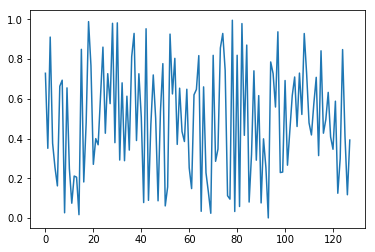

In [28]:

plt.figure()
plt.plot(data[0,:,0])
plt.plot(result[0][0,:,0])
plt.plot(result[3][0,:,0], '-r')
plt.show()

In [30]:
result

[array([[[0.15274462]]], dtype=float32),
 array([[[0.04226144]]], dtype=float32),
 array([[[0.01787122]]], dtype=float32),
 array([[[0.00442098]]], dtype=float32),
 array([[[0.00130569]]], dtype=float32),
 array([[[0.01126683]]], dtype=float32),
 array([[[0.00514121]]], dtype=float32),
 array([[[0.00193884]]], dtype=float32),
 array([[[0.00135131]]], dtype=float32),
 array([[[0.00395645]]], dtype=float32),
 array([[[0.00129559]]], dtype=float32),
 array([[[0.00025828]]], dtype=float32),
 array([[[2.8428185e-05]]], dtype=float32),
 array([[[4.442244e-06]]], dtype=float32),
 array([[[6.41373e-08]]], dtype=float32)]